## PHSX 815 Neural Network with Keras tutorial
### How can we predict the quality of wine based on its physical characteristics?
We will download the `wine_quality` dataset from Tensorflow (the Keras backend) to train a neural network to predict wine quality.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import SGD, Adam
# from tensorflow.keras.activations import relu
import tensorflow_datasets as tfds
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
#if you want to load the data as tuples, you can use the as_supervised=True argument
data_train = tfds.load('wine_quality',split='train',as_supervised=True)

#looking at just one sample of our data
pt = data_train.take(1)
# type(pt)

#can convert this TakeDataset object to a numpy array (can do this for the whole dataset too)
print("Features and label for first entry")
for features, label in tfds.as_numpy(pt):
    print(features,label)

#we want to load dataset as a a dictionary of tf.Tensors (can't transform tuples to dataframe)
data_train_white = tfds.load('wine_quality/white',split='train')
data_train_red = tfds.load('wine_quality/red',split='train')

#transform dictionary to dataframe - combining red and white wine
df_white = tfds.as_dataframe(data_train_white)
df_red = tfds.as_dataframe(data_train_red)
df = pd.concat([df_white,df_red])

print('number of samples',len(df['quality']))

#what are our output possibilities?
print('possible wine quality ratings',df['quality'].unique())

Features and label for first entry
{'alcohol': 9.0, 'chlorides': 0.054, 'citric acid': 0.34, 'density': 1.0008, 'fixed acidity': 7.6, 'free sulfur dioxide': 44.0, 'pH': 3.22, 'residual sugar': 18.35, 'sulphates': 0.550000011920929, 'total sulfur dioxide': 197.0, 'volatile acidity': 0.32} 5
number of samples 6497
possible wine quality ratings [5 6 4 8 7 3 9]


In [3]:
#do we have any missing data (empty or NaN entries in features or labels)?
dataNans = df.isnull().values.any()
if not dataNans:
    print("all good!")

all good!


### Preprocessing our labels
Although this may seem like a regression task for a neural network because we are predicting a number (wine quality), the labels are actually *categorical* not *continuous*. If you look at the labels, you see that they are integer values between 5 and 9. Because this is a classification problem, we need to one-hot encode our labels. This means taking our possible outcomes and turning them into arrays of a 1 and 0's. The index of the 1 in the array will tell us which class is which. So, for example, 5 becomes [1,0,0,0,0], 6 becomes [0,1,0,0,0] and so on. We can use a function from sklearn to do this automatically.

this dataset unfortunately only gives us training data - but we can set aside a portion for testing our network on. in practice, you don't want to test your network on data it has already seen (is it really a prediction if you use your model on data it was fitted to?) but, for educational purposes, we can ~randomly sample our data and call it ~iid.
Here, I combine the red and white wine datasets for increased statistics. What happens if you train networks on these datasets separately? Or what happens if you use one dataset to train and one to test?

In [4]:
#it's helpful to separate our input features from our target features (quality) 
#so we can later only transform our inputs without changing our labels
labels = df['quality']
df = df.drop(labels='quality',axis=1)
labels.unique()

enc = OneHotEncoder(sparse=False)
labels = enc.fit_transform(labels.to_numpy().reshape(-1,1))

#make our test data
df, df_test, labels, df_testLabels = train_test_split(df,labels,test_size=0.1)

#look at the first 5 entries
df.head()

array([5, 6, 4, 8, 7, 3, 9])

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity
2579,10.4,0.036,0.41,0.99200,7.2,33.0,3.17,1.3,0.51,85.0,0.21
444,11.0,0.029,0.18,0.99060,5.7,26.0,3.44,1.4,0.37,104.0,0.32
128,11.3,0.040,0.32,0.99182,6.3,37.0,3.24,4.2,0.43,117.0,0.17
3195,12.9,0.030,0.31,0.98892,5.9,38.0,3.40,2.0,0.41,142.0,0.34
2815,10.5,0.052,0.36,0.99273,6.4,18.0,3.38,2.0,0.53,141.0,0.30


### some questions to consider:
- how was this data obtained? what goes into engineering the features? what does "quality" mean?
- do you have to normalize your features?
- are there any correlations among features? is this expected? how can we encode this information to the NN or decouple these features?
- what does the data look like?
- do we have any missing or NaN entries?

let's examine the data to see what kinds of transformations we need to make for preprocessing

In [5]:
df.describe()

,features/alcohol,features/chlorides,features/citric acid,features/density,features/fixed acidity,features/free sulfur dioxide,features/pH,features/residual sugar,features/sulphates,features/total sulfur dioxide,features/volatile acidity
count,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000,5847.000000
mean,10.501161,0.055964,0.318779,0.994683,7.209826,30.617240,3.218688,5.436549,0.531096,115.708568,0.339414
std,1.195450,0.034349,0.145282,0.003006,1.292639,17.867381,0.160870,4.756639,0.148507,56.519815,0.164678
min,8.000000,0.009000,0.000000,0.987110,3.800000,1.000000,2.720000,0.600000,0.220000,6.000000,0.080000
25%,9.500000,0.038000,0.250000,0.992300,6.400000,17.000000,3.110000,1.800000,0.430000,77.750000,0.230000
50%,10.300000,0.047000,0.310000,0.994890,7.000000,29.000000,3.210000,3.000000,0.510000,118.000000,0.290000
75%,11.300000,0.065000,0.390000,0.996995,7.700000,41.000000,3.320000,8.100000,0.600000,156.000000,0.400000
max,14.200000,0.610000,1.660000,1.038980,15.600000,289.000000,4.010000,65.800003,2.000000,440.000000,1.580000


### Visualizing data
If you want a cool and easy way to visualize not only the features, but also the correlations between features, you can use the following seaborn function, which will display the individual features on the diagonal of the subplots and the correlations between features

`pl = sns.pairplot(df[df.columns], diag_kind='kde')`

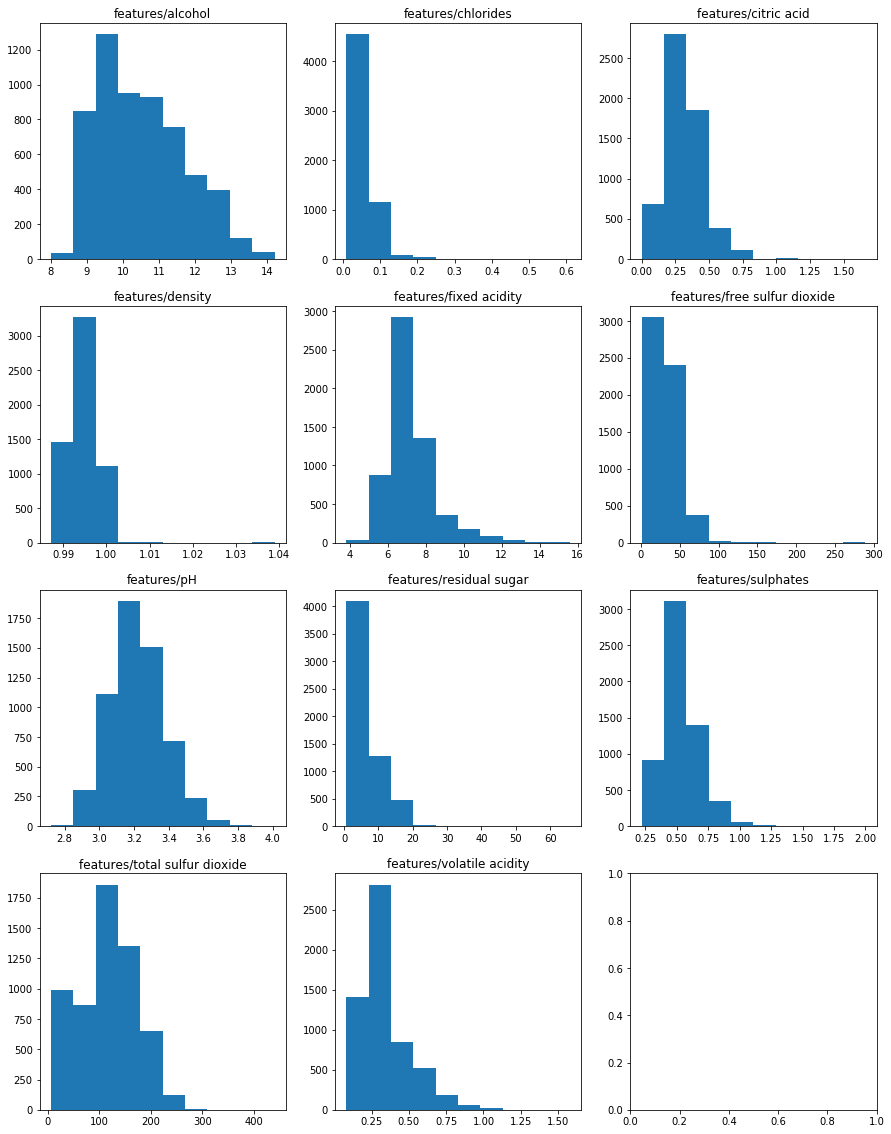

In [6]:
#visualizing our input features
nFeatures = len(df.columns)
nCols = 3
nRows = int(np.ceil(nFeatures/nCols))
cols = df.columns
fig, axs = plt.subplots(nRows,nCols,figsize=(15,20))
# for i, ax in enumerate(axs)
col = 0
for i in range(nRows):
    for j in range(nCols):
        if col >= nFeatures:
            break
        h = axs[i,j].hist(df[cols[col]])
        h = axs[i,j].set_title(cols[col])
        col += 1

It looks like there are two types of sulfur dioxide features: total sulfur dioxide and free sulfur dioxide. I'm not entirely sure what sulfur dioxide is (I am neither a chemist nor a sommelier) so I'm curious if there is a correlation between these features. 

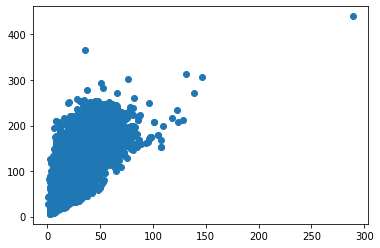

In [7]:
plt.scatter(df['features/free sulfur dioxide'],df['features/total sulfur dioxide'])

It looks like there is some correlation between these features. If I had to guess, I would say "free sulfur dioxide" is a subset of "total sulfur dioxide" but I'm not sure how or even if either of these features would affect the wine quality. This is where domain specific knowledge would be helpful! Since I have a degree in physics and not wine studies (contrary to what my weekend activities may imply) I am going to see what happens when we include both of these features in our network.

This was just a cursory look at our data. In reality, data scientists will spend most of their time feature engineering, fixing incomplete datasets, cleaning data, etc. Feel free to do more exploratory analysis on the data before you pass it through to a network!

## Let's build our network!
We want to build a simple DNN to essentially perform a categorization. Let's start with something simple: only a couple hidden layers and a handful of neurons. Of course, in accordance with the Universal Approximation Theorem, any function can be approximated arbitrarily well with an arbitrarily large number of layers (Lu et. al. 2017) or arbitrarily large number of neurons (Cybenko 1989). Does the network perform better or worse with an increase in layers or neurons?

Let's try to add more layers and add more neurons to see what happens. In this case, 64 neurons per layer and 8 hidden layers.

In [8]:
cols = df.columns
nClasses = len(labels[0])

#using Keras's Sequential model - https://keras.io/api/models/sequential/
model = Sequential()
#add input layer
model.add(Input(shape=(len(cols),))) #the input layer shape should match the number of features we have
#add first layer of fully connected neurons
model.add(Dense(64,activation='relu'))
#add second layer (first hidden layer)
model.add(Dense(64,activation='relu'))
#and one more because why not
model.add(Dense(64,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(64,activation='relu'))
#finally, our output layer should have only one neuron because we are trying to predict only one number
#notice how there is a different activation function in this layer
#this is because we want our outputs for each class to be a probability
model.add(Dense(nClasses,activation='softmax'))

#compile our model - set our loss metric (categorical cross entropy) and optimizer (stochastic gradient descent)
#how does the model performance change with different optimizers (ie AdaGrad, SGD, etc.)?
model.compile(loss='CategoricalCrossentropy',optimizer='Adam',metrics=['accuracy'])

#let's see a summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                768       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4

As shown above, we have a network with four layers, 128 neurons/layer, for a total of ~50k trainable parameters (remember: parameters are the biases and weights that the network learns). Imagine how many parameters a large, complex network at Google has!

### the same model can be built using the generic Model class and slightly different syntax
`
inputs = tf.keras.Input(shape=(len(cols),))
outputs_L1 = Dense(64, activation='relu')(inputs)
outputs_L2 = Dense(64, activation='relu')(outputs_L1)
outputs_L3 = Dense(64, activation='relu')(outputs_L2)
pred = Dense(1)(outputs_L3)
model = Model(inputs=inputs,outputs=pred)
`

### Training our model

Let's give our model all the input features (df), the corresponding labels (labels)

There is a 20% validation split, which means that 80% of our data will be used to train the model parameters
while 20% of it will be saved to "check" our answers. This is data that the model has not seen (been trained on) so the performance on the validation data should give us an idea of if the model is over- or underfitting.

We will train for 100 epochs, which means that the entire dataset will be passed through the whole network 100 times. Our batch size is 20, meaning that 20 samples at a time are passed to the network before the parameters are updated. The `shuffle` argument ensures that our data is shuffled before the beginning of each epoch to reduce spurious learned correlations. What happens if you let the model run for more epochs?


In [9]:
history = model.fit(
    df, labels,
    validation_split=0.3,
    verbose=1, epochs=100, batch_size=100, shuffle=True)

Epoch 1/100
41/41 [==============================] - 0s 6ms/step - loss: 1.3741 - accuracy: 0.4142 - val_loss: 1.3005 - val_accuracy: 0.4353
Epoch 2/100
41/41 [==============================] - 0s 2ms/step - loss: 1.2792 - accuracy: 0.4406 - val_loss: 1.2512 - val_accuracy: 0.4365
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 1.2622 - accuracy: 0.4418 - val_loss: 1.2344 - val_accuracy: 0.4365
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 1.2543 - accuracy: 0.4365 - val_loss: 1.2192 - val_accuracy: 0.4484
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 1.2374 - accuracy: 0.4435 - val_loss: 1.2120 - val_accuracy: 0.4433
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 1.2369 - accuracy: 0.4391 - val_loss: 1.2015 - val_accuracy: 0.4530
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 1.2250 - accuracy: 0.4550 - val_loss: 1.2028 - val_accuracy: 0.4519
Epoch 8/100
4

Epoch 59/100
41/41 [==============================] - 0s 2ms/step - loss: 1.0073 - accuracy: 0.5501 - val_loss: 1.0796 - val_accuracy: 0.5368
Epoch 60/100
41/41 [==============================] - 0s 1ms/step - loss: 1.0156 - accuracy: 0.5545 - val_loss: 1.0732 - val_accuracy: 0.5316
Epoch 61/100
41/41 [==============================] - 0s 1ms/step - loss: 1.0126 - accuracy: 0.5491 - val_loss: 1.0793 - val_accuracy: 0.5276
Epoch 62/100
41/41 [==============================] - 0s 1ms/step - loss: 1.0098 - accuracy: 0.5464 - val_loss: 1.0907 - val_accuracy: 0.5219
Epoch 63/100
41/41 [==============================] - 0s 2ms/step - loss: 1.0167 - accuracy: 0.5469 - val_loss: 1.0735 - val_accuracy: 0.5305
Epoch 64/100
41/41 [==============================] - 0s 2ms/step - loss: 1.0180 - accuracy: 0.5433 - val_loss: 1.0927 - val_accuracy: 0.5293
Epoch 65/100
41/41 [==============================] - 0s 2ms/step - loss: 1.0119 - accuracy: 0.5543 - val_loss: 1.0859 - val_accuracy: 0.5265
Epoch 

Let's define a function to visualize our loss

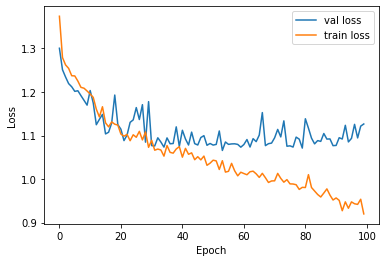

In [10]:
def show_loss(history):
    plt.figure()
    plt.plot(history.history['val_loss'], label="val loss")
    plt.plot(history.history['loss'],label="train loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
show_loss(history)

It looks like our training loss is more or less monotonically minimized with each epoch (with some fluctuations) while the validation loss seems to be on average higher. The validation loss spikes more severely than the training loss, which is probably due to limited statistics (we only had ~6k samples and took onlt 20% of them for validation - it usually takes LOTS of data to train neural networks well!). The trend discrepancy between training and validation losses could indicate some overfitting in our model. What happens if you increase the percentage of data used for validation? Since it's pretty apparent we're overfitting to our training data, we could introduce some sort of regularization techniques, like L2 regularization (that penalizes large weights) or dropout (that randomly drops neurons in a layer with a set probability). What happens if you introduce some of these methods?

### Remember that test data we set aside at the beginning?
Now it's time to use it to evaluate our model performance!

In [11]:
_, acc = model.evaluate(df_test, df_testLabels, verbose=1)
print('Accuracy for test data is',acc)

21/21 [==============================] - 0s 658us/step - loss: 1.1640 - accuracy: 0.4677
Accuracy for test data is 0.4676923155784607


To plot our results, I just chose the highest probability of the classes and assigned the prediction to a class based on that rounding (highest probability gets a 1, every other class gets a 0). Then, I one-hot decoded the rounded array to get a single number for the class. 

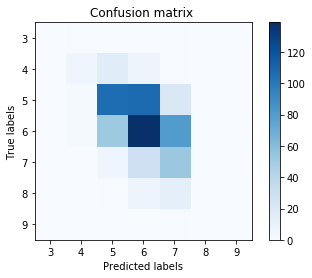

In [12]:
preds = model.predict(df_test)
#preds = [i.round() for i in preds]

preds = tf.one_hot(tf.math.argmax(preds,axis=1), depth=len(preds[0]))

preds = enc.inverse_transform(preds)
testLabels = enc.inverse_transform(df_testLabels)
cm = confusion_matrix(testLabels, preds)

_ =plt.imshow(cm, cmap=plt.cm.Blues)
_ = plt.xlabel("Predicted labels")
_ = plt.ylabel("True labels")

_ =plt.xticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.yticks(np.arange(0,len(np.unique(testLabels)),1),np.unique(testLabels))
_ =plt.title('Confusion matrix ')
_ =plt.colorbar()
plt.show()

It looks like our network is only predicting *some* of our classes. Maybe that's because really good wine (rated 8 and 9) is pretty rare? Let's check it out.

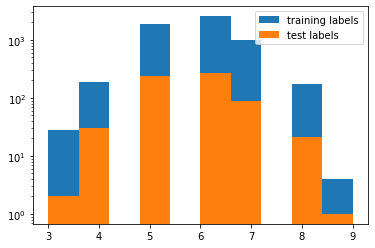

In [13]:
_=plt.hist(enc.inverse_transform(labels),label='training labels')
_=plt.hist(testLabels,label='test labels')
_=plt.yscale('log')
_=plt.legend()

Yep! Mostly 5s, 6s, and 7s. Only a handful of really good wines (8s and 9s) and really bad wines (3s and 4s). In fact, no scores below a 3! But no perfect 10s either. Overall, I would say that the dataset is imbalanced (mostly ok wines, some bad and some good - a pretty Gaussian distribution) and could benefit from data augmentation techniques like bootstrapping! Maybe you could even generate some more data from randomly sampling a known distribution...But if you train your model on mostly ok wines, then it learns the characteristics of those wines really well. So, when it's faced with a good or bad wine, it's not as sure how to classify it. You can see if this is happening by looking at the network output, which are the probabilities for each class (ie how sure the network is this sample belongs to a certain class).

### Overall, 
our network performs ok with a training, validation, and test accuracy all around 50-60%. What could you change about the network or inputs? How do you think that would affect the model's predictions?

With this change, it looks like the confusion matrix is more diagonal, however the validation loss comes apart from the training loss even more than before, which may be indicative of worse overfitting.